In [127]:
import seir_discrete 
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import tkinter as tk
from tkinter import messagebox
import math

In [128]:

def plot_one(ax, method_type, seed_data, 
             start_day, modeled_I, 
             modeled_beta, modeled_days, seed, execution_time):
    '''
    Рисуем график для одного сида.
    
    Параметры:
    - ax -- область для графика
    - method_type -- метод прогноза беты
        ['exp_decay', 'polynom', 'percentiles']
    - seed_data -- датафрейм сида от рег.сети
    - start_day -- день переключения на СИИР модель
    - modeled_I -- смоделированный СИИР компартмент Infected
    - modeled_beta -- смоделированная/спрогнозированная бета
    - modeled_days -- дни прогноза
    '''
    
    predicted_I = np.array(modeled_I)
    actual_I = seed_data.iloc[start_day:]['I'].values
    n = len(predicted_I)
    rmse_I = np.sqrt(mean_squared_error(actual_I[:n], predicted_I[:n]))

        
    # пример:
    # день перехода
    ax.axvline(start_day, ls=':')
    # реальные I, смоделированные I
    ax.plot(seed_data.index, seed_data['I'], ls='--', label='Actual Infections')
    ax.plot(modeled_days, modeled_I,label='Predicted Infections')
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)

    predicted_Beta = np.array(modeled_beta)
    actual_Beta = seed_data.iloc[start_day:]['Beta'].values 
    n_beta = len(predicted_Beta)
    rmse_Beta = np.sqrt(mean_squared_error(actual_Beta[:n_beta], predicted_Beta[:n_beta]))
   
        
    ax_b = ax.twinx()
    # реальная beta, смоделированная beta
    ax_b.plot(seed_data.index, seed_data['Beta'], ls='--', alpha=0.1, label='Actual Beta')
    ax_b.plot(modeled_days, modeled_beta, ls='--', alpha=0.3,label='Predicted Beta ')

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed}, switch {start_day} day, \n'+
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Time: {execution_time:.2e}' ,fontsize=10)
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)
    
    
def model_beta(method_type, days):
    '''
    Моделируем/прогнозируем бету.
    Здесь фиксируем время прогноза беты
    '''
    
    if method_type == 'exp_decay':
        # заглушка
        modeled_betas = [0 for i in days]
        
    elif method_type == 'polynom':
        model_path = 'seir_model_barabasi-alber.joblib'
        # загрузка модели с функции ЭлизабЭтти
        model = load_saved_model(model_path)
        # прогнозируем бету на все оставшиеся дни
        log_beta = model.predict(days.reshape(-1,1))
        modeled_betas = np.exp(log_beta)
        
    elif method_type == 'percentiles':
        # заглушка
        modeled_betas = [0 for i in days]
    
    return modeled_betas
        

def main_f(seir_type, stochastic, start_day, seeds, method_type):
    '''
    Общая функция для построения графиков.
    
    Параметры:
    - method_type -- метод прогноза беты
        ['exp_decay', 'polynom', 'percentiles']
    - seir_type -- модель СИИР для моделирования траектории Infected
        ['seir', 'sir']
    - stochastic -- модель СИИР стохастическая или нет (детерминированная)
    - seed_dirs -- путь к папке с сидами
    - start_day -- день переключения на СИИР модель
    - seeds -- номера сидов
    
    Выход:
        График для сидов.
    '''
    # всегда постоянные
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(len(seeds)//2+math.ceil(len(seeds)%2), 2, figsize=(15, 10))
    axes = axes.flatten()
    
    seed_dirs=f'{seir_type}_30_seeds_v0/'

    for idx, seed in enumerate(seeds):
        
        # читаем данные сида: S,[E],I,R,Beta
        seed_data = pd.read_csv(seed_dirs + f'{seir_type}_seed_{seed}.csv')
        seed_data = seed_data[pd.notna(seed_data['Beta'])]

        # дни для составления прогноза
        modeled_days = np.arange(start_day, seed_data.shape[0])
        # спрогнозированная бета

        start_time = time.time()
        modeled_beta = model_beta(method_type, modeled_days)
        end_time = time.time()
        execution_time = end_time - start_time
        #modeled_beta[seed_data.shape[0]-start_day] = modeled_beta[seed_data.shape[0]-start_day-1]

        # берем значения компартментов в день переключения
        y = seed_data.iloc[start_day].drop('Beta')
    
        # передаем в соответствующую С(И)ИР модель (стохастическую или детерм.)
        # если seir_type == ... , если stochastic == ...
        if seir_type == 'seir':
            if stochastic:
                # пример для seir_type='seir', stype='stochastic'
                res = seir_discrete.seir_model(y, start_day, modeled_days, 
                                    modeled_beta, sigma, gamma, 
                                    stype='stoch', beta_t=True)
                
                # для модели СИР будет: S,I,R = res.T
                S,E,I,R = res.T
            else:
                # пример для seir_type='seir', stype='det'
                res = seir_discrete.seir_model(y, start_day, modeled_days, 
                                    modeled_beta, sigma, gamma, 
                                    stype='det', beta_t=True)
                
                S,E,I,R = res.T
        else:
            if stochastic:
                # пример для seir_type='seir', stype='stochastic'
                res = seir_discrete.sir_model(y, start_day, modeled_days, 
                                    modeled_beta, gamma, 
                                    stype='stoch', beta_t=True)
                
                # для модели СИР будет: S,I,R = res.T
                S,I,R = res.T
            else:
                # пример для seir_type='seir', stype='det'
                res = seir_discrete.sir_model(y, start_day, modeled_days, 
                                    modeled_beta, gamma, 
                                    stype='det', beta_t=True)
                
                # для модели СИР будет: S,I,R = res.T
                S,I,R = res.T
        
        ax = axes[idx]
        # строим один график
        plot_one(ax, method_type, seed_data, start_day, I, modeled_beta, modeled_days, seed, execution_time)        
    
    plt.tight_layout()
    plt.show()

    
        

c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\User\anaconda3\envs\conda2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.1 when using version 1.5.2. This 

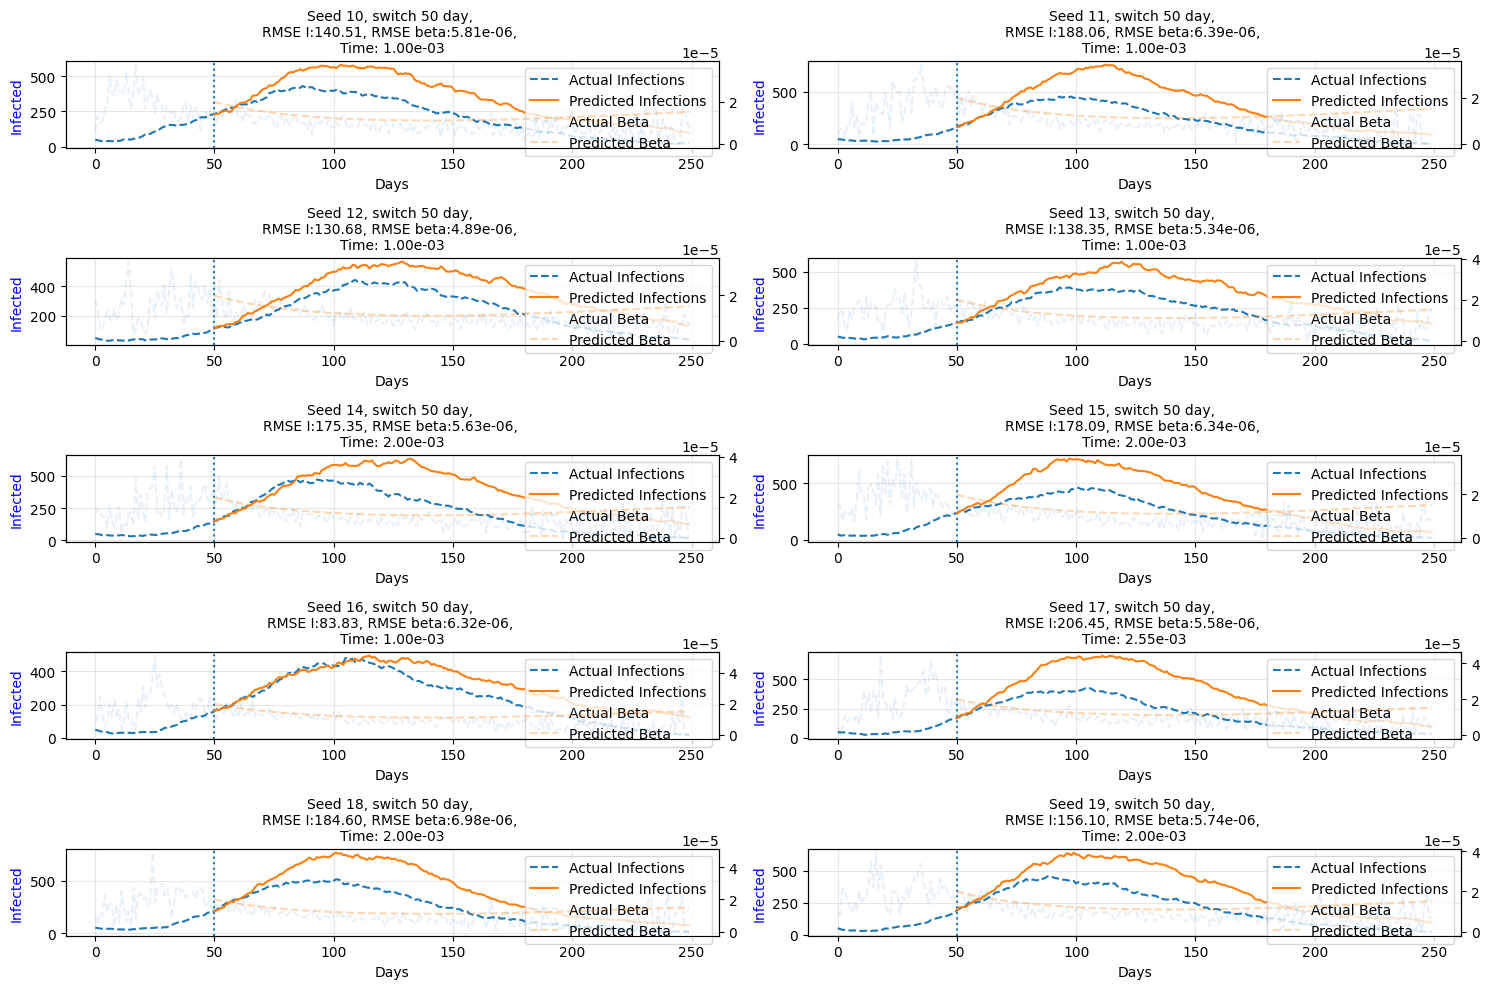

"    \n#Задаем параметры   \nstochastic=True\nstart_day=50 \nseeds = np.arange(10,20)   \nres = main_f('seir',stochastic, start_day, seeds)\n"

In [129]:
'''
создаем графическое окошко для ввода параметров
'''
def parse_seeds(seeds_input):
    seeds = set()  # Используем множество для уникальных значений
    parts = seeds_input.split(',')
    
    for part in parts:
        if '-' in part:  # Если есть тире, значит это диапазон
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # Добавляем все числа в диапазоне
        else:
            seeds.add(int(part))  # Добавляем отдельное семя
            
    return sorted(seeds)  # Возвращаем отсортированный список

def calculate():
    try:
        # Получаем значения из полей ввода
        model = var_model.get()
        stochastic = var_stochastic.get()
        start_day = int(entry_start_day.get())
        seeds_input = entry_seeds.get()
        method_type = var_method_type.get()
        
        # Парсим семена
        seeds = parse_seeds(seeds_input)
        
        # Вызываем основную функцию
        result = main_f(model, stochastic, start_day, seeds, method_type)
        
        # Выводим результат
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")

# Создаем главное окно
root = tk.Tk()
root.title("Ввод параметров")

# Создаем переменную для выбора мат. модели
var_model = tk.StringVar(value="seir")  # Устанавливаем значение по умолчанию

# Создаем выпадающий список для выбора мат. модели
label_model = tk.Label(root, text="Тип математической модели:")
label_model.pack()

model_options = ["seir", "sir"]
dropdown_model = tk.OptionMenu(root, var_model, *model_options)
dropdown_model.pack()

# Создаем флажок для стохастичности
var_stochastic = tk.BooleanVar(value=True)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", variable=var_stochastic)
checkbox_stochastic.pack()

# Создаем метку и поле ввода для start_day
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()

entry_start_day = tk.Entry(root)
entry_start_day.pack()

# Создаем метку и поле ввода для seeds
label_seeds = tk.Label(root, text="Seeds (через запятую или диапазон через тире):")
label_seeds.pack()

entry_seeds = tk.Entry(root)
entry_seeds.pack()

# Создаем переменную для выбора модели прогнозировани beta
var_method_type = tk.StringVar(value='polynom')  # Устанавливаем значение по умолчанию

# Создаем выпадающий список для выбора модели прогнозировани beta
label_method_type = tk.Label(root, text="Тип математической модели:")
label_method_type.pack()

method_type_options = ['polynom', 'exp_decay','percentiles' ]
dropdown_method_type = tk.OptionMenu(root, var_method_type, *method_type_options)
dropdown_method_type.pack()

# Создаем кнопку для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack()

# Запускаем главный цикл приложения
root.mainloop()

'''    
#Задаем параметры   
stochastic=True
start_day=50 
seeds = np.arange(10,20)   
res = main_f('seir',stochastic, start_day, seeds)
'''